# Location extraction and visualization


Our first goal is to see what locations appear in the text and look at their distribution. Let's start by loading all the necessary modules.


In [97]:
# generally useful packages
import re
import pprint
import glob, os, requests
import pickle
import collections

# for data management, visualization and math
import pandas as pd
import numpy as np
#import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# NLP packages, we work with German text so we load that
import nltk
import spacy
nlp = spacy.load("de_core_news_sm")

# for location detection
from geotext import GeoText



## Building the corpus

Now we read the txt files and build our corpus.

In [8]:
data_path = "../data/interim/pdf2text"

data_files = glob.glob(data_path + os.path.sep + "*.txt"); data_files

data_files = [item.replace(data_path + os.path.sep, "") for item in data_files]  # Strip the dir name and the path separator from begining

corpus = []

for txt_file in data_files:
    with open(data_path + os.path.sep + txt_file, encoding='utf8', "r") as f:
        corpus.append(f.readlines())
        
        

Let's see how many documents are loaded:

In [22]:
len(corpus)

25

# Finding locations in the text (NER with Spacy)

Now, we use the Spacy's nlp pipeline to process the corpus. This includes tokenizing, taggind, parsing, identifying and labeling named entities (exactly what we want).

In [23]:
nlp_corpus = []
for idx, raw in enumerate(corpus):
    joined = ' '.join(raw) # we join the docs (which are lists of strings)
    joined_nlp = nlp(joined) 
    nlp_corpus.append(joined_nlp)
    

Now, let's find the sentences that include named entities labeled as LOC. As we go, we put the results into a dataframe.

In [66]:
sents_with_loc = pd.DataFrame({'doc number': [], 'location': [], 'sentence': []})

for idx, doc in enumerate(nlp_corpus):
    for sent in doc.sents:
        locations = []
        for ent in sent.ents:
            if ent.label_ == "LOC":
                locations.append(ent.text)
        if locations:
            sents_with_loc.loc[len(sents_with_loc)] =[idx, locations, sent]

Let's see what we have.

In [25]:
sents_with_loc.head(10)

,doc number,location,sentence
0,0.0,[Berlin],"(Lebensraum, GrÃ¼ndach, \n \n , Inhalt, \n \n..."
1,0.0,[Deutschlands],"(Auf, dem, Besucherzentrum, der, International..."
2,0.0,[BiodiversitÃ¤tsdach],"(Ein, ,, ,, upgrade, "", bereits, existierender..."
3,0.0,[Folien],"(An, einzelnen, Stellen, der, DachflÃ¤che, wur..."
4,0.0,[Totholz],"(10, \n \n , Einbringung, von, Totholz, \n )"
5,0.0,[StÃ¤mme],"(Abgestorbene, Ã„ste, und, StÃ¤mme, stellen, e..."
6,0.0,[www.tu-berlin.de],"(www.dachgaertnerverband.de, \n \n , www.tu-be..."
7,0.0,[Blaufelden-Raboldshausen],"(So, kam, das, Material, fÃ¼r, die, Bepflanzun..."
8,0.0,[Schorndorf],"(Ansprechpartner, im, Bereich, der, Nisthilfen..."
9,0.0,[Falkensee],"(FÃ¼r, das, Totholz, zeichnete, sich, die, Fir..."


It is clear that there are plenty of tokens that are actually not addresses we were looking for.

In [28]:
# make doc numbers an integer
sents_with_loc['doc number'] = sents_with_loc['doc number'].astype(int)

# number of sentences
len(sents_with_loc)

8251

# Identifying coutries and cities (GeoText)

Now, let's catch the country and city mentions using GeoText. Here is a simple example how it works:

In [71]:
cdict = GeoText('New York, Texas, and also Warsaw').country_mentions
cdict

OrderedDict([('US', 2), ('PL', 1)])

The GeoText function is not flawless as illustrated here:
    

In [69]:
places = GeoText("Munchen")
places.country_mentions

OrderedDict()

For our text:

In [72]:
sents_with_loc['country mentions'] = pd.Series([GeoText(str(sent)).country_mentions for sent in sents_with_loc['sentence']],
                                               index = sents_with_loc.index)

sents_with_loc['cities'] = pd.Series([GeoText(str(sent)).cities for sent in sents_with_loc['sentence']],
                                               index = sents_with_loc.index)

In [73]:
sents_with_loc.head(10)

,doc number,location,sentence,country mentions,cities
0,0.0,[Berlin],"(Lebensraum, GrÃ¼ndach, \n \n , Inhalt, \n \n...","{'DE': 1, 'SE': 1}","[Berlin, Boden]"
1,0.0,[Deutschlands],"(Auf, dem, Besucherzentrum, der, International...",{'DE': 1},[Berlin]
2,0.0,[BiodiversitÃ¤tsdach],"(Ein, ,, ,, upgrade, "", bereits, existierender...",{},[]
3,0.0,[Folien],"(An, einzelnen, Stellen, der, DachflÃ¤che, wur...",{},[]
4,0.0,[Totholz],"(10, \n \n , Einbringung, von, Totholz, \n )",{},[]
5,0.0,[StÃ¤mme],"(Abgestorbene, Ã„ste, und, StÃ¤mme, stellen, e...",{},[]
6,0.0,[www.tu-berlin.de],"(www.dachgaertnerverband.de, \n \n , www.tu-be...",{},[]
7,0.0,[Blaufelden-Raboldshausen],"(So, kam, das, Material, fÃ¼r, die, Bepflanzun...",{},[]
8,0.0,[Schorndorf],"(Ansprechpartner, im, Bereich, der, Nisthilfen...",{'DE': 1},[Schorndorf]
9,0.0,[Falkensee],"(FÃ¼r, das, Totholz, zeichnete, sich, die, Fir...",{'DE': 1},[Falkensee]


In any case, let's discard the rows without any location detected for now:

In [74]:
m = sents_with_loc['country mentions'] != {}
sents_with_loc = sents_with_loc[m]
sents_with_loc.head()

,doc number,location,sentence,country mentions,cities
0,0.0,[Berlin],"(Lebensraum, GrÃ¼ndach, \n \n , Inhalt, \n \n...","{'DE': 1, 'SE': 1}","[Berlin, Boden]"
1,0.0,[Deutschlands],"(Auf, dem, Besucherzentrum, der, International...",{'DE': 1},[Berlin]
8,0.0,[Schorndorf],"(Ansprechpartner, im, Bereich, der, Nisthilfen...",{'DE': 1},[Schorndorf]
9,0.0,[Falkensee],"(FÃ¼r, das, Totholz, zeichnete, sich, die, Fir...",{'DE': 1},[Falkensee]
10,0.0,"[Berlin, Brandenburg, AusbildungsfÃ¶rderwerks ...","(Und, die, Gestaltung, der, BiodiversitÃ¤tsmod...",{'DE': 1},[Berlin]


We can do a save here:

In [75]:
sents_with_loc.to_csv('sents_with_loc.csv', encoding='utf-8-sig')

## Counting cities and countries

Next, we'll count each country and city occurence.

In [89]:
country_count = collections.defaultdict(int)

for index, row in sents_with_loc.iterrows():
    #countries
    
    for code, value in  row['country mentions'].items():
        country_count[code] += value 

country_count

defaultdict(int,
            {'DE': 1285,
             'SE': 23,
             'CI': 3,
             'NL': 17,
             'FR': 52,
             'US': 129,
             'UZ': 2,
             'CH': 28,
             'KZ': 1,
             'CN': 18,
             'GB': 22,
             'KW': 12,
             'CA': 8,
             'NO': 4,
             'ID': 5,
             'MY': 1,
             'SG': 7,
             'BE': 10,
             'IN': 8,
             'PT': 17,
             'IL': 18,
             'TW': 1,
             'ZA': 4,
             'AT': 22,
             'IT': 5,
             'RU': 4,
             'JP': 7,
             'NP': 1,
             'ES': 9,
             'PH': 3,
             'HU': 10,
             'SK': 1,
             'AU': 3,
             'KR': 4,
             'BR': 2,
             'MX': 7,
             'IR': 4,
             'VE': 1,
             'CL': 2,
             'MR': 1,
             'BG': 2,
             'TR': 1,
             'HK': 12,
             'DK': 

In [81]:
city_count = collections.defaultdict(int)

for index, row in sents_with_loc.iterrows():
    #cities
    for city in row['cities']:
        city_count[city] += 1
    
city_count

defaultdict(int,
            {'Berlin': 401,
             'Boden': 23,
             'Schorndorf': 3,
             'Falkensee': 3,
             'Hamburg': 109,
             'Stuttgart': 149,
             'Hannover': 40,
             'Kornwestheim': 12,
             'Ludwigsburg': 8,
             'Lage': 20,
             'Karlsruhe': 12,
             'Man': 3,
             'Horst': 1,
             'Adlershof': 4,
             'Mannheim': 21,
             'Bonn': 21,
             'Bad Honnef': 6,
             'Bochum': 5,
             'Darmstadt': 18,
             'Auch': 39,
             'Wiesbaden': 5,
             'Bremen': 13,
             'Kassel': 9,
             'Chicago': 9,
             'Konstanz': 1,
             'Magdeburg': 2,
             'Best': 4,
             'Neustadt': 2,
             'Verl': 4,
             'Pop': 2,
             'Baden': 4,
             'Oldenburg': 4,
             'Solon': 1,
             'Aral': 1,
             'Bad Hersfeld': 1,
             'Leipzi

Which countries were mentioned the most?

In [90]:
country_data = pd.DataFrame({
   'country code':[pair[0] for pair in country_mentions],
    'freq':[pair[1] for pair in country_mentions]})

country_data = country_data.sort_values(by = 'freq', ascending = False)
country_data.head(10)

,country code,freq
0,DE,1285
1,US,129
2,FR,52
3,CH,28
4,SE,23
5,GB,22
6,AT,22
7,CN,18
8,IL,18
10,PT,17


Ommiting Germany, we have the following barchart:

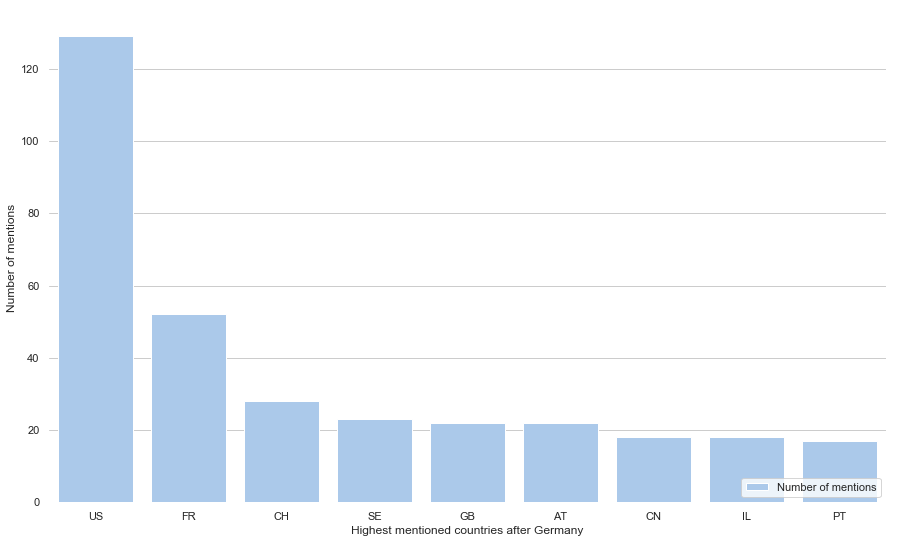

In [104]:
f, ax = plt.subplots(figsize=(15, 9))

sns.set_color_codes("pastel")

sns.barplot(y=data.loc[1:10,"freq"], x=data.loc[1:10,"country code"], 
            label="Number of mentions", color="b")

# labels
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Number of mentions",
        xlabel="Highest mentioned countries after Germany")
sns.despine(left=True, bottom=True)

## Visualization on maps

Let's visualize this! We get coordinates for the countries first:

In [93]:
url = 'https://developers.google.com/public-data/docs/canonical/countries_csv'
html = requests.get(url).content
df_coords = pd.read_html(html)
df_coords = df_coords[0]
df_coords.head()

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


We use folium to put markers proportional to the frequencies:

In [96]:
 # Make an empty map
m = folium.Map(location=[20,0], tiles="Mapbox Bright", zoom_start=2)
data = country_data

# we add markers one by one to the map
for i in range(1,20):
    code = data.iloc[i]['country code']
    lon = int(df_coords[df_coords['country'] == code]['longitude'])
    lat = int(df_coords[df_coords['country'] == code]['latitude'])
    folium.Circle(
      location=[lat, lon],
      popup = code + ': ' + str(data.iloc[i]['freq']) + ' mentions', # pop-up label above marker
      radius = int(data.iloc[i]['freq']) * 10000,
      color = 'crimson',
      fill = True,
      fill_color = 'crimson'
   ).add_to(m)

m.save('world_mentions.png')

m

In [152]:
city_count

defaultdict(int,
            {'Berlin': 395,
             'Schorndorf': 3,
             'Falkensee': 3,
             'Hamburg': 93,
             'Stuttgart': 144,
             'Hannover': 44,
             'Kornwestheim': 12,
             'Ludwigsburg': 9,
             'Karlsruhe': 13,
             'Man': 3,
             'Boden': 20,
             'Adlershof': 4,
             'Mannheim': 20,
             'Bonn': 19,
             'Köln': 37,
             'Bad Honnef': 6,
             'Bochum': 5,
             'Darmstadt': 16,
             'Rostock': 1,
             'Bremen': 15,
             'Auch': 37,
             'Lage': 16,
             'Wiesbaden': 5,
             'Kassel': 7,
             'Chicago': 9,
             'Konstanz': 1,
             'Magdeburg': 2,
             'Ende': 6,
             'Neustadt': 1,
             'Solon': 1,
             'Aral': 1,
             'Bad Hersfeld': 1,
             'Leipzig': 22,
             'Ingolstadt': 10,
             'Sheffield': 3,
       

## Cities from Germany 

Let's look at Germany now and focus on the cities, simply counting first:

In [109]:
city_count_german = collections.defaultdict(int)
for city, count in city_count.items():
    place = GeoText(city)
    if 'DE' in place.country_mentions:
        city_count_german[city] += count

from operator import itemgetter 
city_count_german_sorted = sorted(city_count_german.items(), key = itemgetter(1), reverse = True)
city_count_german_sorted[:10]

[('Berlin', 401),
 ('Stuttgart', 149),
 ('Hamburg', 109),
 ('Ditzingen', 49),
 ('Hannover', 40),
 ('Dresden', 25),
 ('Essen', 24),
 ('Leipzig', 23),
 ('Mannheim', 21),
 ('Bonn', 21)]

The barchart now looks as follows:

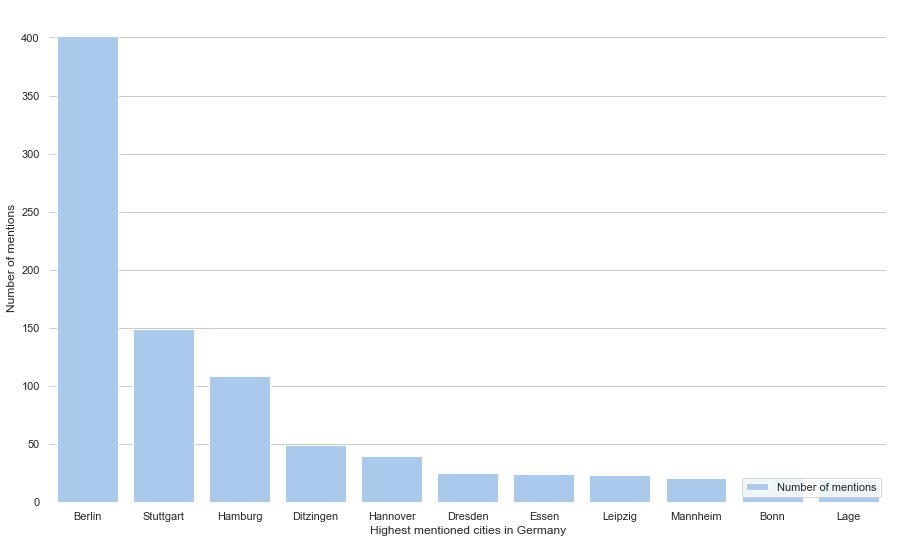

In [110]:
data = pd.DataFrame({
   'country code':[pair[0] for pair in city_count_german_sorted],
    'freq':[pair[1] for pair in city_count_german_sorted]})

f, ax = plt.subplots(figsize=(15, 9))

sns.set_color_codes("pastel")
sns.barplot(y=data.loc[0:10,"freq"], x=data.loc[0:10,"country code"], 
            label="Number of mentions", color="b")

# legend
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Number of mentions",
        xlabel="Highest mentioned cities in Germany")
sns.despine(left=True, bottom=True)

To map these as well, we get a map for the cities:

In [113]:
df_cities = pd.read_csv('../assets/worldcities.csv')
german_cities = df_cities[df_cities['country'] == 'Germany']
german_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6279,Berlin,Berlin,52.5218,13.4015,Germany,DE,DEU,Berlin,primary,3406000.0,1276451290
6280,Cologne,Cologne,50.9300,6.9500,Germany,DE,DEU,North Rhine-Westphalia,NaN,1004000.0,1276015998
6281,Munich,Munich,48.1299,11.5750,Germany,DE,DEU,Bavaria,admin,1275000.0,1276692352
6282,Potsdam,Potsdam,52.4004,13.0700,Germany,DE,DEU,Brandenburg,admin,218095.0,1276395100
6283,Kiel,Kiel,54.3304,10.1300,Germany,DE,DEU,Schleswig-Holstein,admin,269427.0,1276305306


The map now looks like this:

In [116]:
city_list = list()
not_found = list()

m2 = folium.Map(location=[51,10], tiles="Mapbox Bright", zoom_start=6)
 
    
for city, count in city_count.items():
    city_info = german_cities[german_cities['city'] == city]
    if count > 0 and len(city_info) > 0:
        city_list.append(city)
        #mask = german_cities['city'] == city
        lat = float(city_info['lat'])
        lon = float(city_info['lng'])

        folium.Circle(
        location=[lat, lon],
        popup = city + ':' + str(count) + ' mentions',
        radius = count * 150,
        color = 'crimson',
        fill = True,
        fill_color = 'crimson'
        ).add_to(m2)
    if len(city_info) == 0:
        not_found.append((city, count))
m2.save('germany_counts.html')

#print(not_found)
m2

## Green corridors - future project proposal

In the future, it would be nice to map green areas in a city and estimate the price of achieving large, connected green areas or so-called green corridors. This would involve: 
<ul>
    <li>satellite image processing,  </li>
        <li>creating schematic graph of the city marking green and non-green areas; </li>
            <li> estimating the cost of making a unit green;  </li>
                <li> finding minimal weight connected subgraphs that contain a given set of green areas. </li>
</ul>
    
The most relevant references:
<ul>
    <li> Conrad, Jon M., et al. "Wildlife corridors as a connected subgraph problem." Journal of Environmental Economics and Management 63.1 (2012): 1-18.
        </li>
    <li> El-Kebir, Mohammed, and Gunnar W. Klau. "Solving the maximum-weight connected subgraph problem to optimality." arXiv preprint arXiv:1409.5308 (2014).
        </li>
  <ul>